## HW6 Training Machine Learning Models

#### This homework can not be dropped even it gets the lowest score in your homework, which means, the score you get from this homework will be counted towards your final grade. The lowest score from HW1 - HW5 will be dropped.

#### Load Python libraries that you will use :

In [252]:
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

#### Load your Analytical Base Table from HW5 :

In [253]:
ABT = pd.read_csv('ABT.csv')

C:\Users\54208\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [254]:
ABT = ABT.drop_duplicates('SessionID')

#### Removing columns that can't be used for the model

In [255]:
ABT.drop('amount_bought',axis =1, inplace=True)
ABT.drop('repeat_buyer',axis=1, inplace=True)
ABT.drop('total_spent', axis=1, inplace=True)
ABT.drop('buy_hour',axis=1, inplace=True)
ABT.drop('cheapest_item_price',axis=1, inplace=True)

#### Adding new features to ABT

In [256]:
click = pd.read_csv('click_sep.csv', low_memory=False)

buy = pd.read_csv('buy_sep.csv',low_memory=False)

In [257]:
click.head()

,SessionID,TimeStamp,ItemID,Category
0,9293568,2014-09-01 18:07:00.855000+00:00,214853225,S
1,9293653,2014-09-01 10:38:47.087000+00:00,214834871,S
2,9293653,2014-09-01 10:39:49.115000+00:00,214849327,S
3,9293653,2014-09-01 10:40:31.736000+00:00,214828970,S
4,9293653,2014-09-01 10:41:01.640000+00:00,214849327,S


In [258]:
buy.head()

,SessionID,TimeStamp,ItemID,Price,Quantity
0,9641594,2014-09-01 09:09:25.575000+00:00,214853342,2093,2
1,9641594,2014-09-01 09:09:25.596000+00:00,214853340,837,2
2,9641594,2014-09-01 09:09:25.614000+00:00,214853420,1046,2
3,9431393,2014-09-01 13:38:48.351000+00:00,214846258,941,1
4,9431393,2014-09-01 13:38:48.414000+00:00,214853340,837,1


In [259]:
#New Feature 1: The number of times looked at popular categories
top5_category = click['Category'].value_counts().head().index.tolist()
popular_category_df = click[~click['Category'].isin(top5_category)]
newfeature1 = popular_category_df.groupby('SessionID')['SessionID'].count().reset_index(name='popular_category_view_count')
ABT = pd.merge(ABT,newfeature1,on='SessionID',how='left')

In [260]:
#New Feature 2: Whether the session repeatedly looks at the same item
repeat_item_viewers = click[click.duplicated(subset=['SessionID','ItemID'])]['SessionID'].reset_index()
repeat_item_viewers.drop('index',axis=1,inplace=True)
repeat_item_viewers['repeat_item_visitor'] = 1
repeat_item_viewers = repeat_item_viewers.drop_duplicates('SessionID')
newfeature2 = repeat_item_viewers
ABT = pd.merge(ABT,newfeature2,on='SessionID',how='left')

In [262]:
#New Feature 3: The number of times looked at a top 10 popular item
top10_popular_item = click['ItemID'].value_counts().head(10).index.tolist()
top_item_df = click[click['ItemID'].isin(top10_popular_item)]
newfeature3 = top_item_df.groupby('SessionID')['SessionID'].count().reset_index(name='times_looked_at_popular_item')
ABT = pd.merge(ABT,newfeature3,on='SessionID',how='left')

In [264]:
#New Feature 4: Whether the sessions have only visited once
sessionID_counts = click.groupby('SessionID')['SessionID'].count().reset_index(name='Single_session_visit')
newfeature4 = sessionID_counts[sessionID_counts['Single_session_visit'] == 1]
ABT = pd.merge(ABT,newfeature4,on='SessionID',how='left')

In [266]:
#New feature 5: Whether the session is in the top 10% visits the website
session_visits = click.groupby('SessionID')['SessionID'].count().reset_index(name='top_session_visits').sort_values('top_session_visits',ascending=False)
top_10_percent_visitors = session_visits.head(9999)
top_10_percent_visitors['top_visitor'] = 1
newfeature5 = top_10_percent_visitors[['SessionID','top_visitor']]
ABT = pd.merge(ABT,newfeature5,on='SessionID',how='left')

<ipython-input-266-1a505a24b2cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_percent_visitors['top_visitor'] = 1


#### Data Pre-Processing   -- 20 points 

 Examples: 
 
             Categorical data encoding 
             Missing data imputation 
             Data normalization and standardization 
             Split train and test datasets

##### Categorical Data Encoding

In [268]:
ABT['Category'].value_counts()

S             65462
1              9897
2              5627
3              5542
0              3831
5              2238
6              2056
7              1953
4              1269
8               964
9               499
11              324
10              168
12              147
2089287217        3
2089286907        3
2089538467        3
2089404239        2
2089437536        2
2089221555        2
2089615685        1
2089318666        1
2088973177        1
2089422131        1
2089300095        1
2088966377        1
Name: Category, dtype: int64

In [269]:
ABT['Category'] = ABT.apply(lambda x: 64 if x['Category'] == 'S' else x['Category'], axis = 1)

##### Missing Data

In [270]:
ABT['SessionID'].value_counts()

10487807    1
10445497    1
10508958    1
9851551     1
11248289    1
           ..
9303316     1
10091797    1
11265302    1
10196248    1
10092544    1
Name: SessionID, Length: 99998, dtype: int64

In [271]:
ABT['hasBought'].value_counts()

0    50000
1    49998
Name: hasBought, dtype: int64

In [272]:
ABT['item_cnt_in_ses'].value_counts()

2      21920
1      12690
3      12036
4       8342
5       5773
       ...  
143        1
146        1
163        1
181        1
92         1
Name: item_cnt_in_ses, Length: 168, dtype: int64

In [273]:
ABT = ABT[ABT['item_cnt_in_ses'] != 's']

In [274]:
ABT['click_weekday'].value_counts()

0    24880
6    22349
3    12591
2    12456
5    12442
4    12424
1     2855
Name: click_weekday, dtype: int64

In [275]:
ABT['ave_item_price'] = ABT['ave_item_price'].fillna(0)

<ipython-input-275-e4b7fd58f53c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABT['ave_item_price'] = ABT['ave_item_price'].fillna(0)


In [276]:
ABT['click_hour'].value_counts()

18    7785
19    7449
17    6841
8     6425
9     6409
10    6026
11    5999
16    5977
15    5936
7     5820
14    5605
12    5520
13    5498
20    4967
6     4598
5     2620
21    2551
4     1205
22    1112
23     462
3      428
0      299
2      245
1      220
Name: click_hour, dtype: int64

In [277]:
ABT['repeat_visitor'].isna().sum()

0

In [278]:
ABT['popular_category_view_count'] = ABT['popular_category_view_count'].fillna(0)

<ipython-input-278-f96b4f5521d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABT['popular_category_view_count'] = ABT['popular_category_view_count'].fillna(0)


In [279]:
ABT['repeat_item_visitor'] = ABT.apply(lambda x: 1 if x['repeat_item_visitor'] == 1 else 0, axis=1)

<ipython-input-279-0f391c54982d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABT['repeat_item_visitor'] = ABT.apply(lambda x: 1 if x['repeat_item_visitor'] == 1 else 0, axis=1)


In [280]:
ABT['times_looked_at_popular_item'] = ABT['times_looked_at_popular_item'].fillna(0)

<ipython-input-280-abd5edc9dc57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABT['times_looked_at_popular_item'] = ABT['times_looked_at_popular_item'].fillna(0)


In [281]:
ABT['Single_session_visit'] = ABT['Single_session_visit'].fillna(0)

<ipython-input-281-db783ea51952>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABT['Single_session_visit'] = ABT['Single_session_visit'].fillna(0)


In [284]:
ABT['top_visitor'] = ABT['top_visitor'].fillna(0)

<ipython-input-284-2ea03d0cf665>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABT['top_visitor'] = ABT['top_visitor'].fillna(0)


##### Data Normalization

In [287]:
ABT = ABT.apply(pd.to_numeric, errors='coerce')

In [288]:
normalized_ABT = ABT.copy()

In [289]:
ABT_Normalization = normalized_ABT.iloc[:,1:]

In [290]:
normalized_ABT.iloc[:,1:] = (ABT_Normalization - ABT_Normalization.min())/ (ABT_Normalization.max() - ABT_Normalization.min())

In [291]:
normalized_ABT.head()

,SessionID,hasBought,item_cnt_in_ses,click_weekday,ave_item_price,click_hour,Category,CategoryCount,repeat_visitor,popular_category_view_count,repeat_item_visitor,times_looked_at_popular_item,Single_session_visit,top_visitor
0,9293568,0.0,0.000000,0.0,0.003137,0.782609,3.062764e-08,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
1,9293653,0.0,0.020408,0.0,0.027395,0.434783,3.062764e-08,0.021127,0.0,0.0,1.0,0.0,0.0,0.0
2,9293662,1.0,0.005102,0.0,0.005526,0.260870,3.062764e-08,0.007042,0.0,0.0,1.0,0.0,0.0,0.0
3,9293704,1.0,0.005102,0.0,0.004518,0.782609,3.062764e-08,0.007042,0.0,0.0,1.0,0.0,0.0,0.0
5,9293442,1.0,0.010204,0.0,0.003776,0.521739,3.062764e-08,0.014085,0.0,0.0,0.0,0.0,0.0,0.0


##### Data Split

In [292]:
y = normalized_ABT['hasBought']
x = normalized_ABT.drop('hasBought',axis=1)

In [293]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

#### Develop two machine learning models to predict buy or not buy event, you can use any machine learning algorithms that we learned from class, or other ones not learning in class

Each model training -- 15 points\
Model validation -- 15 points , you can use f1, plot roc curve or roc auc score for evaluation

##### Logistic Regression

In [294]:
logistic_regression = LogisticRegression()

In [295]:
logistic_regression.fit(x_train,y_train)

LogisticRegression()

In [296]:
y_pred = logistic_regression.predict_proba(x_test)

In [297]:
y_pred = y_pred[:,1]

In [298]:
y_pred

array([0.50140613, 0.50127265, 0.50125979, ..., 0.50122793, 0.50137584,
       0.50122812])

In [299]:
fpr, tpr, threshold = metrics.roc_curve(y_test,y_pred)

In [300]:
roc_auc = metrics.roc_auc_score(y_test,y_pred)

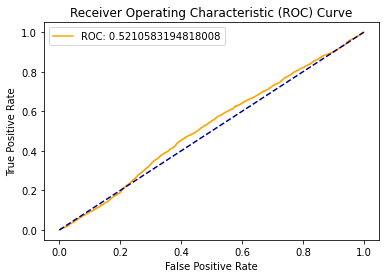

In [301]:
plt.plot(fpr,tpr,color='orange', label='ROC: ' + str(roc_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

##### Decision Tree

In [302]:
decision_classifier = DecisionTreeClassifier()
decision_classifier.fit(x_train, y_train)

DecisionTreeClassifier()

In [303]:
dt_y_pred = decision_classifier.predict_proba(x_test)

In [304]:
dt_y_pred = dt_y_pred[:,1]

In [305]:
dt_fpr, dt_tpr, dt_threshold = metrics.roc_curve(y_test,dt_y_pred)

In [306]:
dt_roc_auc = metrics.roc_auc_score(y_test,dt_y_pred)

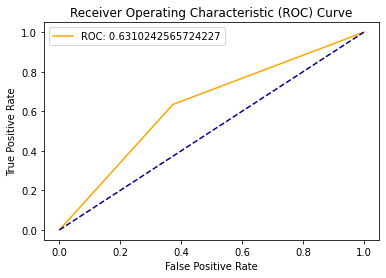

In [307]:
plt.plot(dt_fpr,dt_tpr,color='orange', label='ROC: ' + str(dt_roc_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Explain pros and cons in each of your models; explain your evaluation results from training and test dataset and which model you would recommend.
### This is not a coding task but use your writing skills.

-- 20 points

#### Put your writing in Markdown :

### Logistic Regression

#### Pros
Logistic Regression models are easier to implement, interpret, and train. The model makes no assumptions about distributions of classes in the features. The model can easily adjust to multiple classes. The logistic regression model can be used to measure the appropriateness of a predictor and whether that predictor is positive or negative. It can also be used to interpret the model coefficients for feature importance. It's less inclined for overfitting with high dimension datasets.

#### Cons
It may be overfit if the number of observations are less than the number of features. There are linear boundaries for the model. Logistic regression also assumes that there is linearity between dependent variables and independent variables. Logistic regression should be used to predict discrete functions. Non linear problems can't be solved with logistic regression, and linear separated data isn't found often in real world scenarios. Other algorithms are also able to outperform this algorithm easily. 

### Decision Tree

#### Pros

It's easier to understand and interpret a decision tree since it more closely mimics the human decision making process. It also can work with numerical and categorical features as well. It requires less processing of the data. It's non-parametric. The feature selection is more automatic since unimportant features won't influence the result. Features that depend on each other also don't affect the quality of the model.


#### Cons

They are unstable, so a small data change can lead to a large change in the structure. They're also relatively inaccurate compared to some other predictors. Decision trees can also lead to overfitting of the data. Decision trees are also less suitable for large datasets since the tree may become too complex. 

### Recommendation

For the logistic regression model I created, there doesn't seem to be much of a benefit in using the model. Based off of the ROC value of 0.521, the predictive ability of the logistic regression model is negligible. It would only predict whether the session would have bought or would not have bought as good as a random guess. Based purely off of the ROC, the decision tree would be a better model to use. The ROC for the decision tree was a .631, so it is better at predicting whether the customer would buy or not buy. Although the decision tree predicted the outcome better than the logistic regression model, decision trees are known for overfitting the data. Although I have split the data into training and test data, the decision tree model may still have overfit to the dataset. This decision tree may not be accurate when given the originally large dataset. The decision tree in this scenario still works better than the logistic regression, there would just need to be further evaluations to see how the model would work with the whole dataset.